In [22]:
import pandas as pd
import numpy as np
import datetime
import json
import cv2
import matplotlib.pyplot as plt

In [2]:
video_gt = {}
with open("video_groundtruth.json", "r") as read_file:
    video_gt = json.load(read_file)
FLIR_val_gt = {}
with open("FLIR_val_groundtruth.json", "r") as read_file:
    FLIR_val_gt = json.load(read_file)

In [3]:
video_preds = {}
with open("video_predictions.json", "r") as read_file:
    video_preds = json.load(read_file)
FLIR_val_preds = {}
with open("FLIR_val_predictions.json", "r") as read_file:
    FLIR_val_preds = json.load(read_file)

In [4]:
from intersecting_detect import getIoU   

In [5]:
def getIoUTable(gts, preds):
    table = np.zeros((len(gts), len(preds)))
    for g in range(len(gts)):
        for p in range(len(preds)):
            table[g][p] = getIoU(gts[g], preds[p])
#     print(table, table.shape)
    return table

In [6]:
#video_tables
IoU_threshold = 0.5

In [7]:
%%time
columns = ['Frame_Number', 'FLIR0_Video1', 'Object_Index', 'Start_Time', 'Detected', 'Max_Intersected_CNT', 'IOU', 
          'X', 'Y', 'W', 'H', 'Frame_Int', 'GT_Int']
video_gt_table = pd.DataFrame(columns=columns)
video_gt_table = video_gt_table.astype({"Frame_Number": str, 'FLIR0_Video1': np.bool,
               'Object_Index': np.uint8, "Start_Time": np.datetime64, 'Detected': np.bool,
               'Max_Intersected_CNT': np.uint8, 'IOU': np.float, 'X': np.uint8, 'Y': np.uint8,
               'W': np.uint8, 'H': np.uint8, 'Frame_Int': np.float, 'GT_Int': np.float})


columns = ['Frame_Number', 'FLIR0_Video1', 'Object_Index', 'Start_Time', 'True_False', 'Intersected_GTs', 'IOUs',
           'X', 'Y', 'W', 'H', 'Frame_Int', 'CNT_Int', 'Canny']
video_pred_table = pd.DataFrame(columns=columns)
video_pred_table = video_pred_table.astype({"Frame_Number": str, 'FLIR0_Video1': np.bool,
               'Object_Index': np.uint8, "Start_Time": np.datetime64, 'True_False': np.bool,
               'Intersected_GTs': object, 'IOUs': object, 'X': np.uint8, 'Y': np.uint8,
               'W': np.uint8, 'H': np.uint8, 'Frame_Int': np.uint8, 'CNT_Int': np.float, 'Canny': np.float})


for im_path in list(video_gt.keys()):
    gts = video_gt[im_path]
    frame = cv2.imread(im_path, 0)
    frame_int = frame.mean()
    
    preds = video_preds[im_path]
    table = getIoUTable(gts, preds)
    
   # print(table)
    
    for i, gt in enumerate(gts):
        x,y,w,h = gt
        gt_int = frame[y:y+h,x:x+w].mean()
        if len(table) != 0 :
            max_IoU = table[i,:].max()
            max_cnt = table[i,:].argmax()
        else:
            max_IoU = 0
            max_cnt = None
        video_gt_table = video_gt_table.append(pd.Series(
                        ['Video_'+im_path[-9:-5], True, i, pd.Timestamp('now'), max_IoU > IoU_threshold, max_cnt, max_IoU, 
                             x, y, w, h, frame_int, gt_int]
                            , index=video_gt_table.columns), ignore_index=True)
        
    for j, pred in enumerate(preds):
        x,y,w,h = pred
        pred_int = frame[y:y+h,x:x+w].mean()
        if len(table) != 0 :
            all_gts = table[:,j]
            max_IoU = all_gts.max()
            intersected_gts = np.argwhere(all_gts > 0)
            IoUs = all_gts[intersected_gts]
        else:
            max_IoU = 0
            intersected_gts = None
            IoUs = None
        video_pred_table = video_pred_table.append(pd.Series(
                ['Video_'+im_path[-9:-5], True, j, pd.Timestamp('now'), max_IoU > IoU_threshold, 
                 intersected_gts, IoUs, x, y, w, h, frame_int, pred_int, 0]
                , index=video_pred_table.columns), ignore_index=True)

Wall time: 2min 11s


In [9]:
display(video_gt_table)
display(video_pred_table)

,Frame_Number,FLIR0_Video1,Object_Index,Start_Time,Detected,Max_Intersected_CNT,IOU,X,Y,W,H,Frame_Int,GT_Int
0,Video_1000,True,0,2019-12-13 17:49:00.392557,False,4,0.439331,556,74,18,30,100.311552,176.477778
1,Video_1000,True,1,2019-12-13 17:49:00.408558,False,6,0.201909,622,77,13,25,100.311552,177.984615
2,Video_1001,True,0,2019-12-13 17:49:01.803638,False,6,0.430769,556,74,18,30,100.256686,177.618519
3,Video_1001,True,1,2019-12-13 17:49:01.813639,False,8,0.198171,622,77,13,25,100.256686,177.787692
4,Video_1002,True,0,2019-12-13 17:49:02.054653,False,6,0.439331,556,74,18,30,100.269043,175.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,Video_1498,True,1,2019-12-13 17:51:10.754014,False,5,0.206553,567,86,20,29,94.070282,146.401724
1640,Video_1498,True,2,2019-12-13 17:51:10.763014,True,4,0.784815,510,150,78,169,94.070282,117.504248
1641,Video_1499,True,0,2019-12-13 17:51:10.991027,False,4,0.307278,552,79,21,38,94.031491,178.020050
1642,Video_1499,True,1,2019-12-13 17:51:10.999028,False,4,0.223335,567,86,20,29,94.031491,143.537931


,Frame_Number,FLIR0_Video1,Object_Index,Start_Time,True_False,Intersected_GTs,IOUs,X,Y,W,H,Frame_Int,CNT_Int,Canny
0,Video_1000,True,0,2019-12-13 17:49:00.417559,False,[],[],32,521,17,28,100.311552,102.573529,0.0
1,Video_1000,True,1,2019-12-13 17:49:00.426559,False,[],[],172,434,35,41,100.311552,144.378397,0.0
2,Video_1000,True,2,2019-12-13 17:49:00.435560,False,[],[],228,96,22,21,100.311552,135.322511,0.0
3,Video_1000,True,3,2019-12-13 17:49:00.446561,False,[],[],440,0,88,57,100.311552,137.274322,0.0
4,Video_1000,True,4,2019-12-13 17:49:00.455561,False,[[0]],[[0.4393305439330544]],560,67,19,44,100.311552,161.697368,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6717,Video_1499,True,8,2019-12-13 17:51:11.110034,False,[],[],771,84,34,21,94.031491,139.494398,0.0
6718,Video_1499,True,9,2019-12-13 17:51:11.121035,False,[],[],736,0,58,54,94.031491,95.259579,0.0
6719,Video_1499,True,10,2019-12-13 17:51:11.132035,False,[],[],824,506,24,40,94.031491,62.412500,0.0
6720,Video_1499,True,11,2019-12-13 17:51:11.142036,False,[],[],856,506,26,40,94.031491,57.398077,0.0


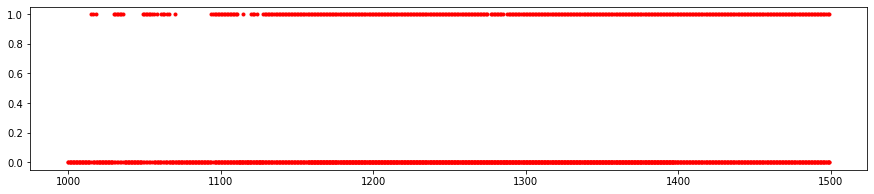

In [28]:
plt.figure(figsize=(15,3))
plt.plot([int(f[6:]) for f in video_gt_table['Frame_Number'].values], video_gt_table['Detected'].values, 'r.')
plt.show()

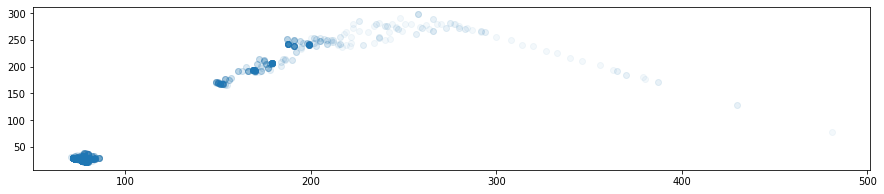

In [57]:
plt.figure(figsize=(15,3))
plt.scatter(video_gt_table['Y'].values, video_gt_table['H'].values , alpha=0.05)
plt.show()

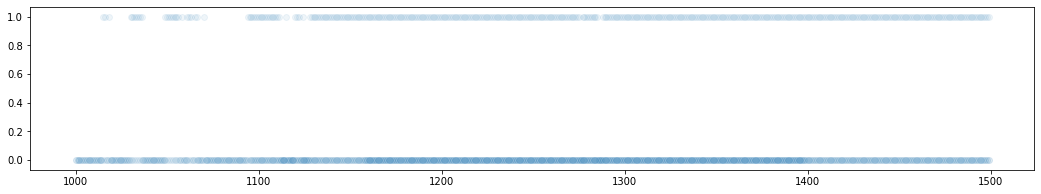

In [46]:
plt.figure(figsize=(18,3))
plt.scatter([int(f[6:]) for f in video_gt_table['Frame_Number'].values], video_gt_table['Detected'].values, alpha=0.07)
plt.show()

array([  540,   325,   540, ...,   798,   580, 13182], dtype=int64)

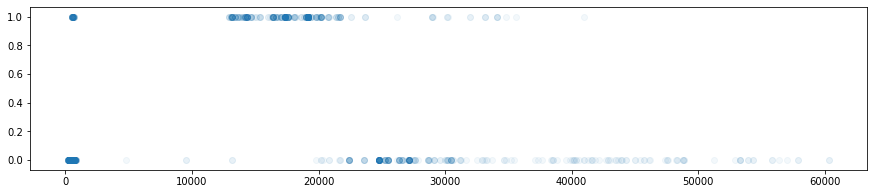

In [50]:
plt.figure(figsize=(15,3))
plt.scatter(video_gt_table['W'].values * video_gt_table['H'].values, video_gt_table['Detected'].values, alpha=0.05)
plt.show()

[1000,
 1000,
 1001,
 1001,
 1002,
 1002,
 1003,
 1003,
 1004,
 1004,
 1005,
 1005,
 1006,
 1006,
 1007,
 1007,
 1008,
 1008,
 1009,
 1009,
 1010,
 1010,
 1011,
 1011,
 1012,
 1012,
 1013,
 1013,
 1014,
 1014,
 1015,
 1015,
 1016,
 1016,
 1017,
 1017,
 1018,
 1018,
 1019,
 1019,
 1020,
 1020,
 1021,
 1021,
 1022,
 1022,
 1023,
 1023,
 1024,
 1024,
 1025,
 1025,
 1026,
 1026,
 1027,
 1027,
 1028,
 1028,
 1029,
 1029,
 1030,
 1030,
 1031,
 1031,
 1032,
 1032,
 1033,
 1033,
 1034,
 1034,
 1035,
 1035,
 1036,
 1036,
 1037,
 1037,
 1038,
 1038,
 1039,
 1039,
 1040,
 1040,
 1041,
 1041,
 1042,
 1042,
 1043,
 1043,
 1044,
 1044,
 1045,
 1045,
 1046,
 1046,
 1047,
 1047,
 1048,
 1048,
 1049,
 1049,
 1050,
 1050,
 1051,
 1051,
 1052,
 1052,
 1053,
 1053,
 1054,
 1054,
 1055,
 1055,
 1056,
 1056,
 1057,
 1057,
 1058,
 1058,
 1059,
 1059,
 1060,
 1060,
 1061,
 1061,
 1062,
 1062,
 1063,
 1063,
 1064,
 1064,
 1065,
 1065,
 1066,
 1066,
 1067,
 1067,
 1068,
 1068,
 1069,
 1069,
 1070,
 1070,
 1071,

In [70]:
1 - gt_table['Detected'].sum()/gt_table['Detected'].count()

0.7463503649635037

In [72]:
1 - pred_table['True_False'].sum()/pred_table['True_False'].count()

0.9379648914013686

In [59]:
columns = ['Frame_Number', 'FLIR0_Video1', 'Object_Index', 'Start_Time', 'Detected', 'Max_Intersected_CNT', 'IOU', 
          'X', 'Y', 'W', 'H', 'Frame_Int', 'GT_Int']
gt_table = pd.DataFrame(columns=columns)
gt_table = gt_table.astype({"Frame_Number": str, 'FLIR0_Video1': np.bool,
               'Object_Index': np.uint8, "Start_Time": np.datetime64, 'Detected': np.bool,
               'Max_Intersected_CNT': np.uint8, 'IOU': np.float, 'X': np.uint8, 'Y': np.uint8,
               'W': np.uint8, 'H': np.uint8, 'Frame_Int': np.float, 'GT_Int': np.float})


columns = ['Frame_Number', 'FLIR0_Video1', 'Object_Index', 'Start_Time', 'True_False', 'Intersected_GTs', 'IOUs',
           'X', 'Y', 'W', 'H', 'Frame_Int', 'CNT_Int', 'Canny']
pred_table = pd.DataFrame(columns=columns)
pred_table = pred_table.astype({"Frame_Number": str, 'FLIR0_Video1': np.bool,
               'Object_Index': np.uint8, "Start_Time": np.datetime64, 'True_False': np.bool,
               'Intersected_GTs': object, 'IOUs': object, 'X': np.uint8, 'Y': np.uint8,
               'W': np.uint8, 'H': np.uint8, 'Frame_Int': np.uint8, 'CNT_Int': np.float, 'Canny': np.float})


for im_path in list(FLIR_val_gt.keys()):
    gts = FLIR_val_gt[im_path]
    frame = cv2.imread(im_path, 0)
    frame_int = frame.mean()
    
    preds = FLIR_val_preds[im_path]
    table = getIoUTable(gts, preds)
    
   # print(table)
    
    for i, gt in enumerate(gts):
        x,y,w,h = gt
        gt_int = frame[y:y+h,x:x+w].mean()
        if len(table) != 0 :
            max_IoU = table[i,:].max()
            max_cnt = table[i,:].argmax()
        else:
            max_IoU = 0
            max_cnt = None
        gt_table = gt_table.append(pd.Series(
                        ['FLIR_'+im_path[-9:-5], True, i, pd.Timestamp('now'), max_IoU > IoU_threshold, max_cnt, max_IoU, 
                             x, y, w, h, frame_int, gt_int]
                            , index=gt_table.columns), ignore_index=True)
        
    for j, pred in enumerate(preds):
        x,y,w,h = pred
        pred_int = frame[y:y+h,x:x+w].mean()
        if len(table) != 0 :
            all_gts = table[:,j]
            max_IoU = all_gts.max()
            intersected_gts = np.argwhere(all_gts > 0)
            IoUs = all_gts[intersected_gts]
        else:
            max_IoU = 0
            intersected_gts = None
            IoUs = None
        pred_table = pred_table.append(pd.Series(
                ['FLIR_'+im_path[-9:-5], True, j, pd.Timestamp('now'), max_IoU > IoU_threshold, 
                 intersected_gts, IoUs, x, y, w, h, frame_int, pred_int, 0]
                , index=pred_table.columns), ignore_index=True)

In [60]:
display(gt_table)
display(pred_table)

,Frame_Number,FLIR0_Video1,Object_Index,Start_Time,Detected,Max_Intersected_CNT,IOU,X,Y,W,H,Frame_Int,GT_Int
0,FLIR_8863,True,0,2019-12-13 19:01:36.574642,False,3,0.011161,580,206,34,75,140.909201,209.165098
1,FLIR_8863,True,1,2019-12-13 19:01:36.583643,False,3,0.015231,609,207,30,116,140.909201,215.918103
2,FLIR_8864,True,0,2019-12-13 19:01:36.674648,True,4,0.654408,369,193,74,126,127.433084,141.401652
3,FLIR_8864,True,1,2019-12-13 19:01:36.682649,False,7,0.176127,488,192,49,134,127.433084,172.186567
4,FLIR_8864,True,2,2019-12-13 19:01:36.690649,False,7,0.089270,544,200,32,104,127.433084,202.148438
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2138,FLIR_9651,True,0,2019-12-13 19:03:01.696511,False,0,0.000000,114,188,40,137,136.708417,212.900000
2139,FLIR_9651,True,1,2019-12-13 19:03:01.705512,False,0,0.000000,152,167,60,187,136.708417,211.818806
2140,FLIR_9652,True,0,2019-12-13 19:03:01.796517,False,13,0.205128,410,215,24,56,131.505838,210.787202
2141,FLIR_9652,True,1,2019-12-13 19:03:01.806517,False,13,0.109127,433,216,13,55,131.505838,215.061538


,Frame_Number,FLIR0_Video1,Object_Index,Start_Time,True_False,Intersected_GTs,IOUs,X,Y,W,H,Frame_Int,CNT_Int,Canny
0,FLIR_8863,True,0,2019-12-13 19:01:36.591643,False,[],[],67,331,21,21,140.909201,171.145125,0.0
1,FLIR_8863,True,1,2019-12-13 19:01:36.600644,False,[],[],391,228,27,21,140.909201,120.026455,0.0
2,FLIR_8863,True,2,2019-12-13 19:01:36.612645,False,[],[],424,226,37,22,140.909201,97.242015,0.0
3,FLIR_8863,True,3,2019-12-13 19:01:36.622645,False,"[[0], [1]]","[[0.011160714285714286], [0.01523109243697479]]",0,155,640,357,140.909201,171.957493,0.0
4,FLIR_8863,True,4,2019-12-13 19:01:36.631646,False,[],[],0,96,40,24,140.909201,163.218750,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5375,FLIR_9668,True,2,2019-12-13 19:03:04.150651,False,None,None,160,232,16,38,132.373392,160.044408,0.0
5376,FLIR_9668,True,3,2019-12-13 19:03:04.161652,False,None,None,195,238,21,22,132.373392,177.458874,0.0
5377,FLIR_9668,True,4,2019-12-13 19:03:04.171653,False,None,None,192,196,18,22,132.373392,142.699495,0.0
5378,FLIR_9668,True,5,2019-12-13 19:03:04.182653,False,None,None,256,225,144,76,132.373392,168.687957,0.0


In [61]:
print(1 - gt_table['Detected'].sum()/gt_table['Detected'].count(), 
     1 - pred_table['True_False'].sum()/pred_table['True_False'].count())

0.9687354176388241 0.987732342007435


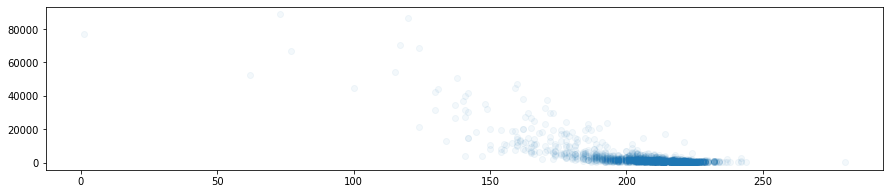

In [68]:
plt.figure(figsize=(15,3))
plt.scatter(gt_table['Y'].values, gt_table['H'].values*gt_table['W'].values, alpha=0.05)
plt.show()

In [67]:
gt_table['Y'].values.max()

280

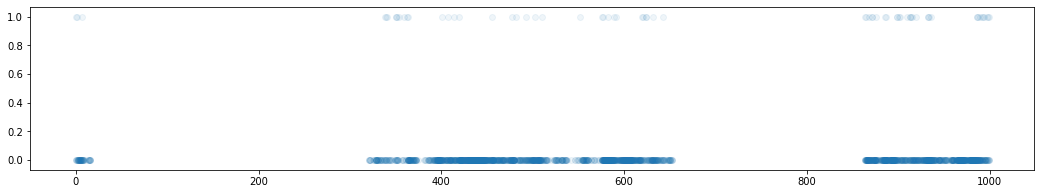

In [70]:
plt.figure(figsize=(18,3))
plt.scatter([int(f[6:]) for f in gt_table['Frame_Number'].values], gt_table['Detected'].values, alpha=0.07)
plt.show()

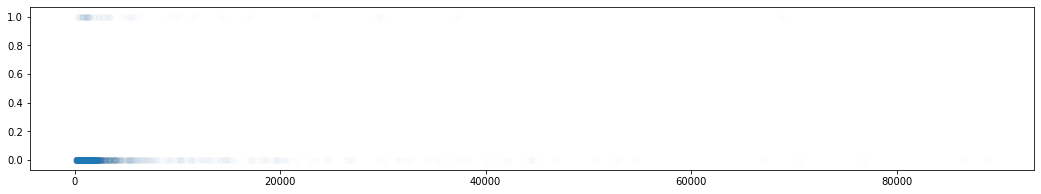

In [73]:
plt.figure(figsize=(18,3))
plt.scatter(gt_table['W'].values * gt_table['H'].values, gt_table['Detected'].values, alpha=0.01)
plt.show()